In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
class HierachicalAgglomerativeClustering:
    
    def __init__(self, n_clusters = 2, affinity = 'euclidean', linkage = 'ward'):
        self.n_clusters = n_clusters
        self.proximity_matrix = []
        self.affinity = {'euclidean' : self._euclidean_distance}[affinity]
        self.linkage = {'complete' : self._max_similarity, 'average' : self._average_similarity, 'ward' : self._ward_similarity}[linkage]
        self.clusters = None
        self.labels = None
    
    def _ComputeProxmityMatrix(self, n_clusters):
        proximity_matrix = np.ones((n_clusters, n_clusters)) * float('inf')
        for idx1 in range(0, n_clusters - 1):
            for idx2 in range(idx1 + 1, n_clusters):
                c1, c2 = self.clusters[idx1], self.clusters[idx2]
                proximity_value = self.linkage(self._distances(c1, c2), len(c1), len(c2))
                proximity_matrix[idx1][idx2] = proximity_matrix[idx2][idx1] = proximity_value
        
        return proximity_matrix
    
    def _distances(self, c1, c2):
        all_distances = np.array([])
        for row in c1:
            all_distances = np.append(all_distances, self.affinity(c2, row))
        
        return all_distances
    
    def _euclidean_distance(self, X1, X2):
        return np.sqrt(np.sum((X1 - X2) ** 2, axis = 1))
    
    def _max_similarity(self, distances, nc1, nc2): 
        return max(distances)
    
    def _average_similarity(self, distances, nc1, nc2): 
        return np.sum(distances) / (nc1 * nc2)
    
    def _ward_similarity(self, distances, nc1, nc2): 
        return np.sum(np.square(distances)) / (nc1 * nc2)
        
    def _find_min_Index(self, proximity_matrix):
        minimum = float('inf')
        index = (None, None)
        n_clusters = len(proximity_matrix)
        for row_idx in range(0, n_clusters):
            min_proximity_idx = np.argmin(proximity_matrix[row_idx])
            if minimum > proximity_matrix[row_idx][min_proximity_idx]:
                minimum = proximity_matrix[row_idx][min_proximity_idx]
                index = (row_idx, min_proximity_idx)
        
        return index

    def _update_proximity_matrix_and_clusters(self, c1_idx, c2_idx, n_clusters, proximity_matrix, clusters):               
        c1_idx, c2_idx = min(c1_idx, c2_idx), max(c1_idx, c2_idx)
        merged_cluster = np.append(clusters[c1_idx], clusters[c2_idx], axis = 0)
        proximity_matrix = np.delete(proximity_matrix, [c1_idx, c2_idx], axis = 0)
        proximity_matrix = np.delete(proximity_matrix, [c1_idx, c2_idx], axis = 1)
        new_clusters = clusters[: c1_idx] + clusters[c1_idx + 1 : c2_idx] + clusters[c2_idx + 1 : ] + [merged_cluster]
                
        col_for_merged_cluster = np.ones((n_clusters-2)) * float('inf')
        row_for_merged_cluster = np.ones((1, n_clusters-1)) * float('inf')
        proximity_matrix = np.c_[proximity_matrix, col_for_merged_cluster]
        proximity_matrix = np.append(proximity_matrix, row_for_merged_cluster, axis = 0)
        
        for idx in range(0, n_clusters - 2):
            cluster = new_clusters[idx]
            proximity = self.linkage(self._distances(merged_cluster, cluster), len(merged_cluster), len(cluster))
            proximity_matrix[idx][n_clusters-2] = proximity_matrix[n_clusters-2][idx] = proximity
        
        return proximity_matrix, new_clusters

    def fit(self, X):
        self.clusters = list(np.expand_dims(X, axis = 1))
        n_clusters = len(self.clusters)
        self.proximity_matrix = self._ComputeProxmityMatrix(n_clusters)
        while n_clusters > self.n_clusters:
            r, c = self._find_min_Index(self.proximity_matrix)
            self.proximity_matrix, self.clusters = self._update_proximity_matrix_and_clusters(r, c, n_clusters, self.proximity_matrix, self.clusters)
            n_clusters = len(self.clusters)
        self.labels = self.predict(X)
            
    def predict(self, X):
        distances = self._predict_distances(X)
        return np.argmin(distances, axis = 1)
        
    def _predict_distances(self, X):
        X = np.expand_dims(X, axis = 1)
        distances = []
        for sample in X:
            sample_dist = []
            for idx in range(self.n_clusters):
                proximity = self.linkage(self._distances(sample, self.clusters[idx]), 1, len(self.clusters[idx]))
                sample_dist.append(proximity)
            distances.append(sample_dist)
        
        return np.array(distances)
    
def fcnAccuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)

In [4]:
X, y = make_blobs(centers=5, n_samples=500, n_features=2, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [5]:
clusters = len(np.unique(y))

HAC = HierachicalAgglomerativeClustering(n_clusters = clusters)
HAC.fit(X_train)

y_train_pred = HAC.predict(X_train) 
y_test_pred = HAC.predict(X_test)

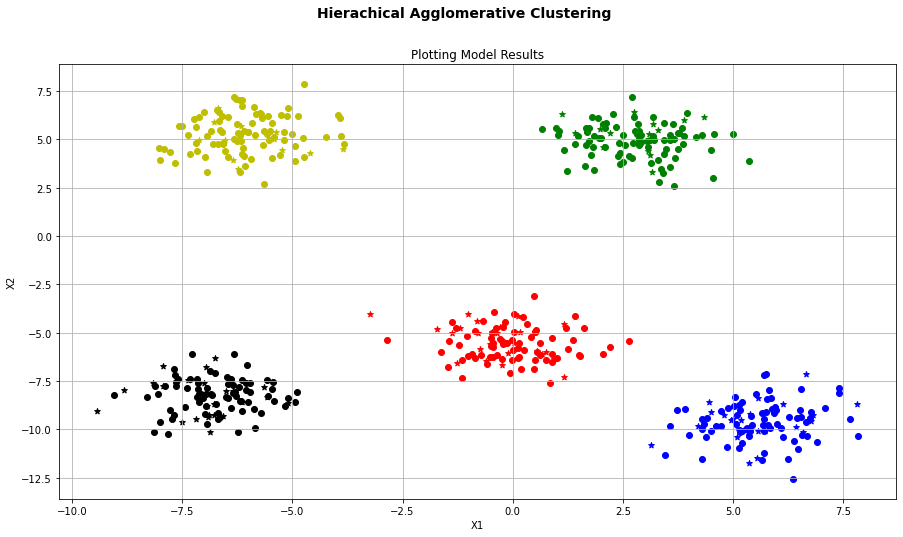

In [6]:
color = ['k', 'b', 'g', 'r', 'y']
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle("Hierachical Agglomerative Clustering", fontsize=14, fontweight="bold")
ax.set_title("Plotting Model Results")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
plt.grid(True)
for idx in range(0, len(y_train_pred)):
    plt.scatter(x = X_train[idx][0], y = X_train[idx][1], color = color[y_train_pred[idx]])
for idx in range(0, len(y_test_pred)):
    plt.scatter(x = X_test[idx][0], y = X_test[idx][1], marker = "*" , color = color[y_test_pred[idx]])
    
plt.show()

In [7]:
ac = AgglomerativeClustering(n_clusters=clusters)
y_pred = ac.fit_predict(X)

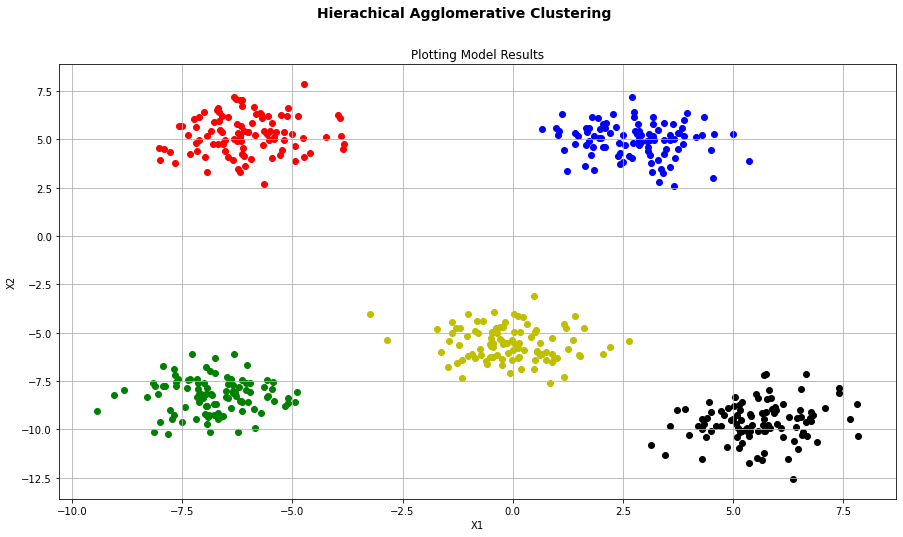

In [8]:
color = ['k', 'b', 'g', 'r', 'y']
fig, ax = plt.subplots(figsize=(15, 8))
fig.suptitle("Hierachical Agglomerative Clustering", fontsize=14, fontweight="bold")
ax.set_title("Plotting Model Results")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
plt.grid(True)
for idx in range(0, len(y_pred)):
    plt.scatter(x = X[idx][0], y = X[idx][1], color = color[y_pred[idx]])
    
plt.show()

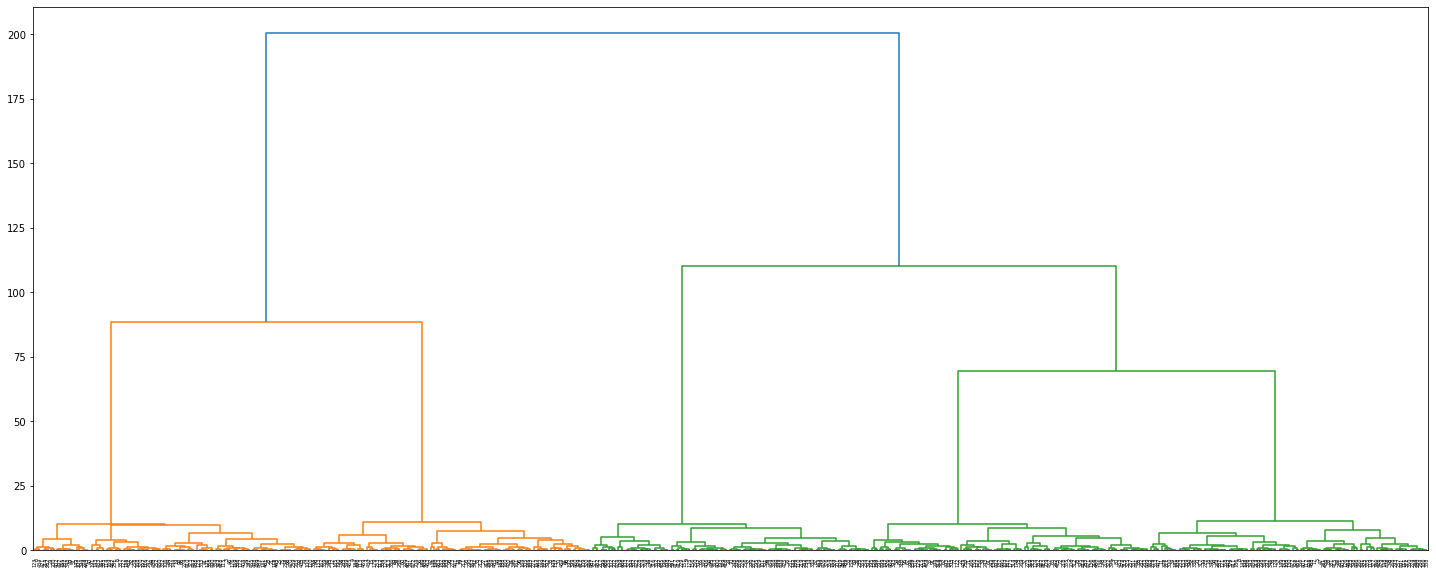

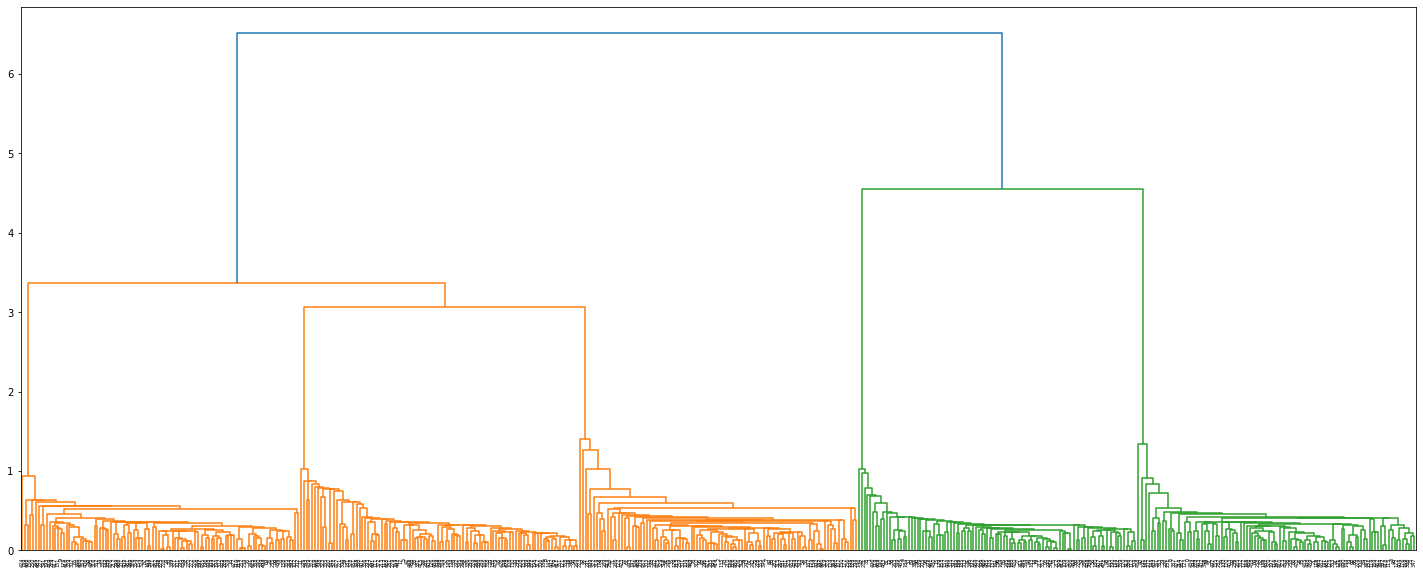

In [9]:
Z = linkage(X, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
Z = linkage(X, 'single')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()